In [13]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from coinmetrics.api_client import CoinMetricsClient
from finquant365.portfolio import build_portfolio
cmap1 = None #'RdYlBu'

In [2]:
# Earliest data to download
start_date = '2019-01-01'

# List of assets to analyze [symbols]
coin_list = ['btc', 'eth', 'ltc', 'link', 'etc']


In [ ]:
""" Selected list of supported coins
Symbol      Name                First Known Date
------      -----               -----------------
btc         Bitcoin             2010-07-19
ltc         Litecoin            2013-04-01
doge        Dogecoin            2014-01-23
xrp         Ripple              2014-08-16
usdt        Tether              2014-10-07
eth         Ethereum            2015-08-09
xlm         Stellar             2015-09-30
etc         Ethereum Classic    2016-07-25
bch         Bitcoin Cash        2017-01-02
bnb         Binance             2017-07-16
mana        Decentraland        2017-08-25
link        Chainlink           2017-09-30
bat         Basic Attention     2017-10-06
ada         Cardano             2017-12-01
trx         TRON                2018-06-25
cro         Cronos              2019-03-20
atom        Cosmos              2019-04-23
matic       Polygon             2019-04-27
sol         Solana              2020-04-11
dot         Polkadot            2020-08-20
ftt         FTX Token           2019-08-20
uni         Uniswap             2020-09-18
avax        Avalanche           2020-09-23
"""

In [5]:
try:
    del df
except NameError:
    pass

# Create a CoinMetrics client object
client = CoinMetricsClient()

# Download all the data
cm_data = client.get_asset_metrics(
    assets=coin_list,
    metrics=['ReferenceRate'],
    start_time=f'{start_date}T00:00:00Z',
    frequency='1d'
)
cm_df = cm_data.to_dataframe()

# Iterate through each asset and extract the data
for key in coin_list:
    tmp_df = cm_df[cm_df['asset'] == key]
    tmp_df = tmp_df.drop(columns=['asset'], axis=1)

    # Rename ReferenceRate to symbol of asset. 
    tmp_df = tmp_df.rename(columns={"ReferenceRate": key.upper()})
    
    # Merge the dataframes if it already exists, otherwise create it
    try:
        df = df.merge(tmp_df, on="time", how="outer")
    except NameError:
        df = tmp_df


In [6]:
# Sort the data b/c CM doesn't return ordered data lmao
df = df.sort_values(by='time')
df = df.set_index(pd.DatetimeIndex(df['time']))

# FinQuant will try to analyze it as an  asset and crash otherwise lols
df = df.drop('time', axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1489 entries, 2019-01-01 00:00:00+00:00 to 2023-01-28 00:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     1489 non-null   Float64
 1   ETH     1489 non-null   Float64
 2   LTC     1489 non-null   Float64
 3   LINK    1489 non-null   Float64
 4   ETC     1489 non-null   Float64
dtypes: Float64(5)
memory usage: 77.1 KB


In [7]:
# Disable future deprecation warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

pf = build_portfolio(data=df)
pf.properties()

----------------------------------------------------------------------
Stocks: BTC, ETH, LTC, LINK, ETC
Time window/frequency: 365
Risk free rate: 0.042
Portfolio Expected Return: 1.024
Portfolio Volatility: 0.869
Portfolio Sharpe Ratio: 1.130

Skewness:
        BTC       ETH       LTC      LINK       ETC
0  0.733357  0.857107  1.401188  1.055333  1.552962

Kurtosis:
        BTC       ETH       LTC      LINK       ETC
0 -0.788275 -0.431653  1.915613  0.354825  2.754161

Information:
   Allocation  Name
0         0.2   BTC
1         0.2   ETH
2         0.2   LTC
3         0.2  LINK
4         0.2   ETC
----------------------------------------------------------------------


In [8]:
# For production quality, I usually do minimum 1,000,000 trials.
# But it takes a couple minutes to run, so for prototyping I stick
# to about 1000 trials. 

# Run the Monte Carlo optimisation
opt_w, opt_res = pf.mc_optimisation(num_trials=20000)

In [9]:
# I've been fighting a lot with mpl since I upgraded to 3.6.2
# Sometimes I need to run this cell twice to get it to work.
# idk man. 

# In later pythons my first runs have been buggy for mpl with custom rcParams.
fig = plt.figure()
plt.close()

# Default plot settings
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.subplot.left'] = 0.08
plt.rcParams['figure.subplot.top'] = 0.92
plt.rcParams['figure.subplot.right'] = 1.00

In [10]:
def source(src_string, fontsize=10):
    ax = plt.gca()
    props = dict(alpha=0)
    ax.text(0.0, -0.10, 
            f"Data Source(s): {src_string}", 
            transform=ax.transAxes, 
            fontsize=fontsize, 
            verticalalignment='bottom', 
            bbox=props,
    )
    return

def timerange(start_str, end_str, fontsize=10):
    ax = plt.gca()
    props = dict(alpha=0)
    ax.text(
        0.0, -0.135, 
        f"Data from: {start_str}, to: {end_str}", 
        transform=ax.transAxes, 
        fontsize=fontsize, 
        verticalalignment='bottom', 
        bbox=props, 
    )  
    return


In [11]:
def plot_best_capital_allocation(ax, data):
    sharpe_ret = data['Expected Return']['Max Sharpe Ratio']
    sharpe_vol = data['Volatility']['Max Sharpe Ratio']
    
    rfr = 0.02
    xx = np.arange(0, 4, 0.1)
    ax.plot(
        xx, 
        (sharpe_ret-rfr)/sharpe_vol*xx + rfr, 
        '--', 
        color = 'purple', 
        lw = 1.25, 
        label = "Best Capital Allocation"
    )
    return


----------------------------------------------------------------------
Optimised portfolio for Maximum Sharpe Ratio

Time window/frequency: 365
Risk free rate: 0.042
Expected annual Return: 1.329
Annual Volatility: 1.009
Sharpe Ratio: 1.276

Optimal weights:
                 BTC       ETH           LTC      LINK       ETC
Allocation  0.034195  0.377878  6.505213e-18  0.567814  0.020113
----------------------------------------------------------------------


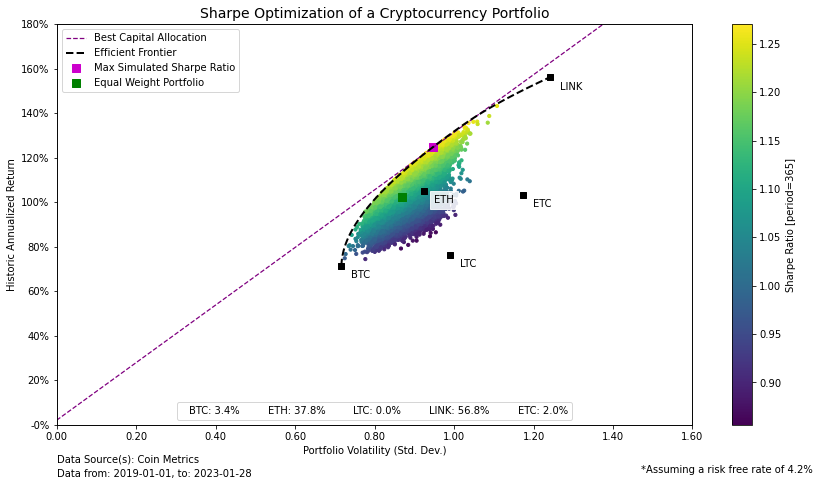

In [14]:
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

plot_best_capital_allocation(ax1, opt_res)
pf.ef_plot_efrontier()
pf.ef_minimum_volatility(verbose=False)
pf.ef_maximum_sharpe_ratio(verbose=True)
pf.ef.plot_optimal_portfolios()
pf.mc_plot_results(cmap1)

plt.legend(loc='upper left')
pf.plot_stocks() # after the legend.
plt.axhline(y=0, color = 'k', lw = 1)

plt.title('Sharpe Optimization of a Cryptocurrency Portfolio', size=14)
ax1.set_xlabel('Portfolio Volatility (Std. Dev.)')
ax1.set_ylabel('Historic Annualized Return')

ax1.set_xticks(np.arange(0, 4.5, 0.2))
ax1.set_yticks(np.arange(-1, 4.5, 0.2))
ax1.set_xlim([0.0, 1.6])
ax1.set_ylim([-0.0, 1.8])

ax1.set_xticklabels(['{:,.2f}'.format(x) for x in ax1.get_xticks()])
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in ax1.get_yticks()])


from datetime import datetime
now = int(datetime.utcnow().timestamp() * 1E6)

# Build a custom legend to display the optimal weights
ax2 = ax1.twinx()
ax2.set_yticks([])
hands = []
for key in opt_w.keys():
    val = pf.ef.df_weights.transpose()[key][0]
    hands.append(mpatches.Patch(
        color='k',
        alpha=0,
        label=f"{key}: {val:,.1%}")
    )

ax2.legend(
    handles=hands, 
    handlelength=0,
    loc='lower center', 
    ncol=6, 
)

plt.annotate(
    f"*Assuming a risk free rate of {pf.ef.risk_free_rate:,.1%}", 
    xy=(0.9, -0.07), 
    xytext=(12, -12), 
    va='top',
    xycoords='axes fraction',
    textcoords='offset points', 
    size=10
)

source('Coin Metrics')
timerange(str(df.index[0])[:10], str(df.index[-1])[:10])
    
plt.savefig(
    f'./images/example-output-s{now}.png', 
    transparent=False, 
    facecolor=ax1.get_facecolor(),
    dpi = 100,
)
plt.show()